# CARREGAR AS ANOTAÇÕES DO XML E RECORTAR AS IMAGENS

In [39]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

In [40]:
import os
import numpy as np # linear algebra
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import uuid


with open(XML_PATH[9]) as annot_file:
    print(''.join(annot_file.readlines()))

In [41]:
BASE_PATH = ['../..','datasets']

DATASET_DIR = os.path.join(BASE_PATH[0],BASE_PATH[1],'PKLot')

path = '/PKLot/UFPR05/todas'
path = os.path.normpath(path)
path = path.split(os.sep)

IMAGE_DIR = os.path.join(DATASET_DIR,path[2],path[3])
XML_DIR = IMAGE_DIR
SAVE_DIR = os.path.join(DATASET_DIR,path[2])

IMAGE_PATH = []
XML_PATH = []
def criarLista():
    for file in os.listdir(IMAGE_DIR):
        if file.endswith(".jpg"):

            file = os.path.join(IMAGE_DIR,file)
            IMAGE_PATH.append(file)
    IMAGE_PATH.sort()

    for file in os.listdir(IMAGE_DIR):
        if file.endswith(".xml"):

            file = os.path.join(XML_DIR,file)
            XML_PATH.append(file)
    XML_PATH.sort()


criarLista()
vagas = 40
pontos = vagas*4
#debug
print(IMAGE_DIR)
print(SAVE_DIR)
print(IMAGE_PATH[:2])
print(XML_PATH[:2])

../../datasets/PKLot/UFPR05/todas
../../datasets/PKLot/UFPR05
['../../datasets/PKLot/UFPR05/todas/2013-02-22_06_05_00.jpg', '../../datasets/PKLot/UFPR05/todas/2013-02-22_06_10_00.jpg']
['../../datasets/PKLot/UFPR05/todas/2013-02-22_06_05_00.xml', '../../datasets/PKLot/UFPR05/todas/2013-02-22_06_10_00.xml']


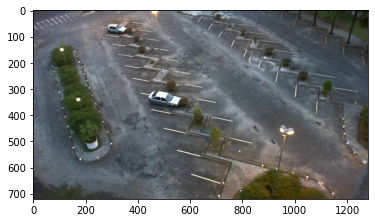

In [42]:
image = plt.imread(IMAGE_PATH[0])
plt.imshow(image)

## Carrega o XML e filtra os pontos X e Y.

In [49]:
tree = ET.parse(XML_PATH[0])
root = tree.getroot()

pts = np.empty(0,np.int32)
vaga = np.empty(0,np.int32)

for neighbor in root.iter('point'):
    #print(neighbor.attrib)
    x,y = neighbor.attrib.values()
    x = int(x)
    y = int(y)
    a = [x,y]
    pts = np.append(pts,[x,y])
    
for neighbor in root.iter('space'):
    #print(neighbor.attrib)
    if(len(neighbor.attrib.values())==2):
        _,occupied = neighbor.attrib.values()
        occupied = int(occupied)
    if(len(neighbor.attrib.values())==1):
        occupied=0
        
    vaga = np.append(vaga,occupied)

#debug
print(pts[0:4])
print(vaga[0:40])

[608 613 741 654]
[0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


## Organiza os pares XY de cada Ponto.

In [50]:
paresXY = np.array(np.zeros((pontos,2)),np.int32) 
j=0
for i in range(pontos):
    paresXY[i] = pts[j:j+2]
    j = j+2

#debug
paresXY[0:4]

array([[608, 613],
       [741, 654],
       [775, 582],
       [608, 526]], dtype=int32)

## CROP (Função que segmenta e salva as imagens segmentadas)

In [51]:
def crop(j=0,i=0,vaga=2,lista=5):
    rect = cv2.boundingRect(paresXY[j:j+4])
    x,y,w,h = rect
    croped = im2[y:y+h, x:x+w].copy()

    pts = paresXY[j:j+4] - paresXY[j:j+4].min(axis=0)
    mask = np.zeros(croped.shape[:2], croped.dtype)
    cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

    ## (3) do bit-op
    dst = cv2.bitwise_and(croped, croped, mask=mask) #background preto

    bg = np.ones_like(croped, np.uint8)*255
    cv2.bitwise_not(bg,bg, mask=mask)
    dst2 = bg+ dst #background branco
    
    image = cv2.resize(dst2, (128,128), interpolation = cv2.INTER_CUBIC)
    arquivo = 'vaga{}_ocupado{}_{}.jpg'.format(i,vaga,lista)
    
    path=os.path.join(SAVE_DIR,'output')
    if not os.path.exists(path):
        os.makedirs(path)
    
    path = os.path.join(SAVE_DIR,'output','livre')
    if not os.path.exists(path):
        os.makedirs(path)
    
    path = os.path.join(SAVE_DIR,'output','ocupada')
    if not os.path.exists(path):
        os.makedirs(path)
    
    if vaga:
        path=os.path.join(SAVE_DIR,'output','ocupada',arquivo)
        cv2.imwrite(path, image)
        
    else:
        path=os.path.join(SAVE_DIR,'output','livre',arquivo)
        cv2.imwrite(path, image)

 

## Cria as delimitações a partir dos pontos do XML
## Exibe a imagem completa com as segmentações
## Chama a função crop para cada vaga delimitada


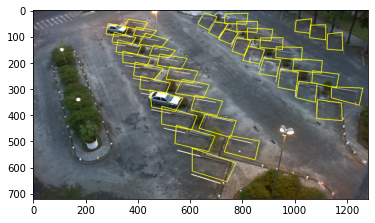

In [52]:
im = cv2.imread(IMAGE_PATH[0])
im2 = im.copy()
if im is None:
    sys.exit("A imagem não foi carregada.")

j=0
for i in range(len(paresXY)//4):
    cv2.polylines(im,[paresXY[j:j+4]],True,(0,255,255),2)
    crop(j,i,vaga[i])
    j=j+4

image = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
plt.imshow(image)

#cv2.imshow("Imagem completa", im)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [47]:
IMAGE_PATH[2]

'../../datasets/PKLot/UFPR05/todas/2013-02-22_06_15_00.jpg'

<img src="./images/output.png" alt="Pasta output" width=300 height=240>

## CROP DA LISTA

In [53]:
%%time

for lista in range (0,len(IMAGE_PATH)):

    #PARTE 1

    tree = ET.parse(XML_PATH[lista])
    root = tree.getroot()

    pts = np.empty(0,np.int32)
    vaga = np.empty(0,np.int32)

    for neighbor in root.iter('point'):
        #print(neighbor.attrib)
        x,y = neighbor.attrib.values()
        x = int(x)
        y = int(y)
        a = [x,y]
        pts = np.append(pts,[x,y])

    for neighbor in root.iter('space'):
        #print(neighbor.attrib)
        if(len(neighbor.attrib.values())==2):
            _,occupied = neighbor.attrib.values()
            occupied = int(occupied)
        if(len(neighbor.attrib.values())==1):
            occupied=0

        vaga = np.append(vaga,occupied)


    #PARTE 2


    paresXY = np.array(np.zeros((pontos,2)),np.int32) 
    j=0
    for i in range(pontos):
        paresXY[i] = pts[j:j+2]
        j = j+2

    #PARTE 3


    im = cv2.imread(IMAGE_PATH[lista])
    im2 = im.copy()
    if im is None:
        sys.exit("A imagem não foi carregada.")

    j=0
    for i in range(len(paresXY)//4):
        cv2.polylines(im,[paresXY[j:j+4]],True,(0,255,255),2)
        crop(j,i,vaga[i],lista)
        j=j+4

    print(lista)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [36]:
lista

4151

10
11
12
13
14


In [35]:
len(IMAGE_PATH)

4152

##### UTIL (PECORRER SUBPASTAS)

list_img = []
for root, dirs, files in os.walk(IMAGE_DIR):
    for file in files:
        if file.endswith(".jpg"):
            
            file = os.path.join(IMAGE_DIR,'todas',file)
            list_img.append(file)
list_img.sort()

list_xml = []
for root, dirs, files in os.walk(IMAGE_DIR):
    for file in files:
        if file.endswith(".xml"):
            
            file = os.path.join(IMAGE_DIR,'todas',file)
            list_xml.append(file)
list_xml.sort()

In [77]:
a = uuid.uuid1(clock_seq=True)
a.time_hi_version

4588

In [66]:
uuid.uuid2(NAMESPACE_DNS,pedro)

AttributeError: module 'uuid' has no attribute 'uuid2'